In [1]:
%tensorflow_version 1.4.1

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [3]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda 
from keras.layers import Multiply, Add, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

from keras import initializers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

Using TensorFlow backend.


In [5]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 10
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_______________________________________

In [6]:
# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
__________________________

In [7]:
# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


In [0]:
def plot_loss(losses):
    plt.figure()
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.savefig('./loss.png')
    plt.close()
def plot_gen(mnist=1, n_ex=16, dim=(4,4), figsize=(10,10)):
    noise = np.random.normal(0,1,size=[n_ex,randomDim])
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        if mnist:
          img = generated_images[i,:,:,0]
          plt.imshow(img, cmap='gray')
        else:
          img = generated_images[i,:,:,:]
          plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./images.png')
    plt.close()

In [0]:
def train_epoch(gan, generator, discriminator, plt_frq=25, BATCH_SIZE=32, mnist=1):  
  vector_ind = np.random.permutation(x_train.shape[0])
  nb_epoch = int(x_train.shape[0]/BATCH_SIZE)
  pbar = tqdm_notebook(range(nb_epoch))
  for e in range(nb_epoch):  
    ind = vector_ind[e*BATCH_SIZE:(e+1)*BATCH_SIZE]
    # Make generative images
    image_batch = x_train[ind,:,:,:]    
    noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    generated_images = generator.predict(noise_gen)
    # Train discriminator on generated images
    X = np.concatenate((image_batch, generated_images))
    y = np.zeros([2*BATCH_SIZE])
    y[0:BATCH_SIZE] = 1
    y[BATCH_SIZE:] = 0

    #make_trainable(discriminator,True)
    d_loss  = discriminator.train_on_batch(X,y)
    losses["d"].append(d_loss)
    # train Generator-Discriminator stack on input noise to non-generated output class
    noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    y2 = np.zeros([BATCH_SIZE])
    y2[:] = 1

    #make_trainable(discriminator,False)
    g_loss = gan.train_on_batch(noise_tr, y2 )
    losses["g"].append(g_loss)

    # Updates plots. This is a little bit of a mess due to how the notebook
    # handles the outputs
    if e % plt_frq==plt_frq-1:
      plot_loss(losses)
      plot_gen(mnist)
      fig, ax = plt.subplots(2,1, figsize=(20,10) )
      img=mpimg.imread('loss.png')
      ax[0].imshow(img)
      ax[0].axis('off')
      img=mpimg.imread('images.png')
      ax[1].imshow(img)
      ax[1].axis('off')
      plt.tight_layout()
      display.clear_output(wait=True)
      pbar.update(plt_frq)
      display.display(pbar)
      display.display(fig)
      plt.close()


 96%|<bar/>| 1800/1875 [00:27<00:01, 65.81it/s]

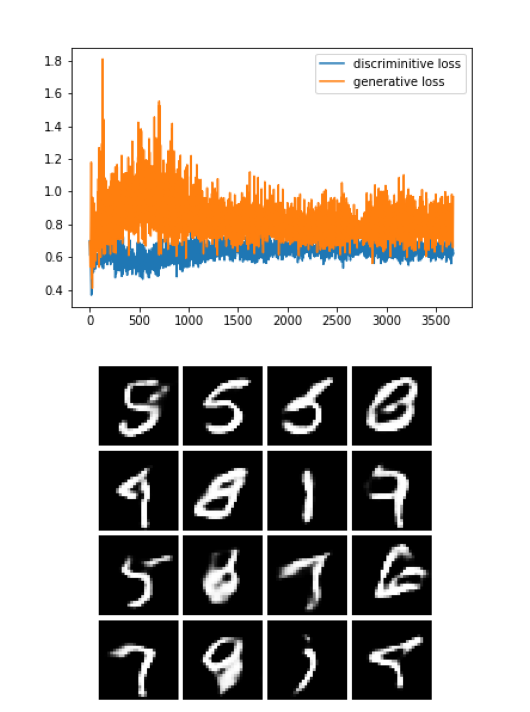

In [10]:
# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 2
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

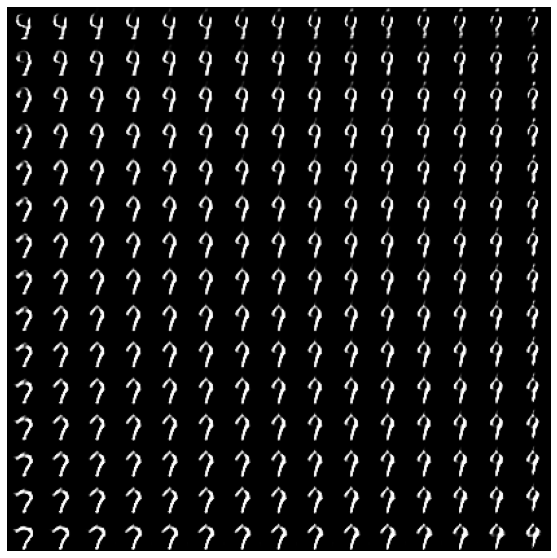

In [11]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [12]:
!wget https://imperialcollegelondon.box.com/shared/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 -O inception_score_mnist.h5
inception_score_model = keras.models.load_model('./inception_score_mnist.h5')

--2020-05-12 13:53:24--  https://imperialcollegelondon.box.com/shared/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 185.235.236.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 [following]
--2020-05-12 13:53:24--  https://imperialcollegelondon.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 [following]
--2020-05-12 13:53:24--  https://imperialcollegelondon.app.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.com

In [0]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
from keras.datasets import mnist
from PIL import Image as pil_image


def inception_score(x, resizer=None, batch_size=32, denorm_im=1):
    r = None
    n_batch = (x.shape[0]+batch_size-1) // batch_size
    for j in range(n_batch):
        x_batch = x[j*batch_size:(j+1)*batch_size, :, :, :]
        if denorm_im:
          x_batch = (x_batch + 1)/2
        r_batch = inception_score_model.predict(x_batch) # r has the probabilities for all classes
        r = r_batch if r is None else np.concatenate([r, r_batch], axis=0)
    p_y = np.mean(r, axis=0) # p(y)
    e = r*np.log(r/p_y) # p(y|x)log(P(y|x)/P(y))
    e = np.sum(e, axis=1) # KL(x) = Σ_y p(y|x)log(P(y|x)/P(y))
    e = np.mean(e, axis=0)
    return np.exp(e) # Inception score


def image_inception_score(generator, n_ex=10000, dim_random=10, input_noise=None, denorm_im=1):
    if input_noise is None:
      input_noise = np.random.normal(0,1,size=[n_ex,dim_random])
    x_pred = generator.predict(input_noise)
    if len(x_pred.shape)==2:
      x_pred = x_pred.reshape(n_ex, 28, 28, 1)
    return inception_score(x_pred, denorm_im=denorm_im)


In [14]:
image_inception_score(generator, dim_random=randomDim, denorm_im=1)

7.3134065

cGan

In [0]:
import keras
from keras.datasets import cifar10, cifar100
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as ktf
import numpy as np
import matplotlib.pyplot as plt
import datetime

class DataLoader():
  def __init__(self, dataset_name, img_res=(32, 32)):
    self.dataset_name = dataset_name
    self.img_res = img_res
    self.load_dataset()
  
  def _start_epoch(self):  
  
    random_idx = np.random.permutation(len(self.im_A_train))
    self.im_A_train_epoch = self.im_A_train[random_idx]
    
  def load_dataset(self):
    
    if self.dataset_name == 'CIFAR10':
      (im_A_train, y_train), (im_A_test, y_test) = cifar10.load_data()
    elif self.dataset_name == 'CIFAR100':
      (im_A_train, y_train), (im_A_test, y_test) = cifar100.load_data()
    else:
      raise Exception('Please, select a valid dataset')
      
    self.im_A_train = im_A_train.astype('float32')
    self.im_A_test = im_A_test.astype('float32')
    self.im_A_train /= 255.
    self.im_A_test /= 255.
    
  def get_dataset_shape(self, is_training=True):
    
    if is_training:
      return self.im_A_train.shape
    else:
      return self.im_A_test.shape
    
  def get_num_batches(self, batch_size):
    return int(self.im_A_train.shape[0] / batch_size)
  
  def set_image_transformations(self, convert_to_bw):
    
    self.convert_to_bw = convert_to_bw
  
  def load_batch(self, batch_size=1, is_training=True):
        
    if is_training:
      
      self._start_epoch()   
      num_batches = int((self.im_A_train).shape[0] / batch_size)
      
    else:
      num_batches = int((self.im_A_test).shape[0] / batch_size)
    
    for idx_batch in range(num_batches):
      
      init = idx_batch * batch_size
      end = (idx_batch + 1) * batch_size
      
      if is_training:
        batch = self.im_A_train_epoch[init:end]
      else:
        batch = self.im_A_test[init:end]
 
      batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
            
      # Convert to B&W
      batch_bw = self.convert_to_bw(batch)
      
      yield [batch, batch_bw]

  def get_random_batch(self, batch_size=1, is_training=True):
    
    if is_training:
      random_idx = np.random.permutation(len(self.im_A_train))
      batch = self.im_A_train[random_idx[0:batch_size]]
    else:
      random_idx = np.random.permutation(len(self.im_A_test))
      batch = self.im_A_test[random_idx[0:batch_size]]

    batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
        
    # Convert to B&W
    batch_bw = self.convert_to_bw(batch)
      
    return [batch, batch_bw]

In [47]:
# Load the data, shuffled and split between train and test sets
dataset_loader = DataLoader(dataset_name = 'CIFAR10')

training_shape = dataset_loader.get_dataset_shape()
test_shape = dataset_loader.get_dataset_shape(is_training=False)

print('Shape of Training Images: {}'.format(training_shape))
print('Shape of Test Images: {}'.format(test_shape))

Shape of Training Images: (50000, 32, 32, 3)
Shape of Test Images: (10000, 32, 32, 3)


In [0]:
import numpy as np
from numpy import isneginf
from scipy.stats import iqr 

def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    #combinedReal = np.real(combined)
    #combinedImag = np.imag(combined)
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

In [0]:
import random
np.random.seed(100)

noise_mag = np.random.uniform(size = (32,32,3),low = 0.0, high = 1.0)
#print(noise_mag[0])

In [0]:
def transformx(img):
    mag,ang = compute_mag_phase(img)
    im = reconstruct(noise_mag,ang)
    return im 

def reconstructAll(imgArray):
    #print(imgArray.shape)
    batch = np.zeros(imgArray.shape)
    for i in range(0,imgArray.shape[0]):
      imgx = imgArray[i,:,:,:]
      #print(imgx.shape)
      batch[i,:,:,:] = transformx(imgArray[i,:,:,:])
    #print(batch.shape)
    return batch

In [0]:
# Convert to greyscale color space

# Set predefined transformation in DataLoader Class
dataset_loader.set_image_transformations(reconstructAll)

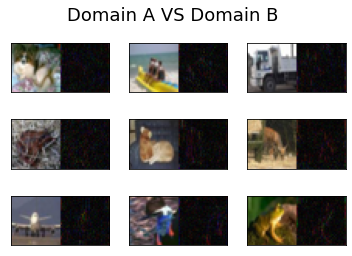

In [95]:
# Load random batch from dataset
random_batch = dataset_loader.get_random_batch(batch_size=9)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 1, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Domain A VS Domain B', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    #print(tmp[idx].shape)
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
from keras.layers import Dropout, merge, concatenate, UpSampling2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Reshape, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, Input, Dense, Reshape, Flatten
from keras.optimizers import Adam

def build_generator(im_shape):
  #print(im_shape)
  
  img_B = Input(shape=(im_shape[0], im_shape[1], 3))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(img_B)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = img_B, outputs = conv10, name='generator')
  
  return model

In [0]:
def build_discriminator(im_shape):
  
  img_A = Input(shape=(im_shape[0], im_shape[1], 3))
  img_B = Input(shape=(im_shape[0], im_shape[1], 3))

  combined_imgs = concatenate([img_A, img_B], axis=-1)
    
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(combined_imgs)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)

  disc_layer = Conv2D(128, kernel_size=(5, 5), strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Flatten()(disc_layer)
  disc_layer = Dense(1024)(disc_layer)

  prob = Dense(1, name="disc_dense")(disc_layer)

  discriminator = Model(inputs=[img_A, img_B], outputs=[prob], name='discriminator')
  
  return discriminator


In [0]:
# Define optimizers for each network.
# Note that if the discriminator is able to differentiate between samples, 
# the generator will be not able to learn. They must learn at the same time.
# Setting the learning rates or learning steps is always tricky.
optimizer_g = Adam(0.0002, 0.5)
optimizer_d = Adam(0.00002, 0.5)

# Input size
im_shape = (32, 32)

# Build and compile the discriminator
discriminator = build_discriminator(im_shape)
discriminator.compile(loss='mse', optimizer=optimizer_d, metrics=['accuracy'])

# Build the generator
generator = build_generator(im_shape)

# Input images and their conditioning images
img_A = Input(shape=(im_shape[0], im_shape[1], 3))
img_B = Input(shape=(im_shape[0], im_shape[1], 3)) ####

# By conditioning on B generate a fake version of A.
# Remember, images in B are the B&W version of images in A
fake_A = generator(img_B)

# For the combined model we will only train the generator, thus, we freeze the
# discriminator model when optimizing G.
# We are backpropagating the discriminator's error
# into the generator in order to create fake images that are unrecognizable by D
discriminator.trainable = False

# Discriminators determines if a conditioned pair has been generated or is real
valid = discriminator([fake_A, img_B])

# Minimize discriminator error (only updating generator's weights) and 
# the L1 loss between real and fake images.
combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer_g)

In [0]:
def showColoredIms(imB, fake_imA, real_imA):
  
  plt.subplot(131)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('Domain B', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(fake_imA[0], 0, 1)) 
  plt.title('Fake A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

def showColored_two_models_Ims(imB, fake_imA_MAE, fake_imA_cGAN, real_imA):
  
  plt.subplot(141)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('BW', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(142)
  plt.imshow(np.clip(fake_imA_MAE[0], 0, 1)) 
  plt.title('MAE', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(143)
  plt.imshow(np.clip(fake_imA_cGAN[0], 0, 1))
  plt.title('cGAN', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(144)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

In [105]:
num_epochs = 20
batch_size = 128
n_batches = dataset_loader.get_num_batches(batch_size)

# Adversarial loss ground truths. 
# They are used as labels for the discriminator loss.
valid = np.ones((batch_size,))
fake = np.zeros((batch_size,))
     
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []
  d_avg_loss = []
  d_avg_acc = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size)):
      
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Condition on B and generate a translated (fake) version of A.
    # It will try to color images from B to be as similiar as possible 
    # to their correspoding pairs from A.
    fake_A = generator.predict(imgs_B)      

    # Train the discriminator (original images = real / generated = Fake)
    d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
    d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_avg_loss.append(d_loss[0])
    d_avg_acc.append(d_loss[1])
    
    # -----------------
    #  Train Generator
    # -----------------

    # Train the generators
    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
    g_avg_loss.append(g_loss[0])
    
    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%50 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      

    # Plot the progress
    if batch_i%10 == 0:          

      print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(d_avg_loss), 100*np.mean(d_avg_acc), np.mean(g_avg_loss), elapsed_time, remaining_time))            
        
  # Saves optimizer and weights
  generator.save('generator.h5') 
  discriminator.save('discriminator.h5')

Output hidden; open in https://colab.research.google.com to view.

In [103]:
generator = keras.models.load_model('./generator.h5')
discriminator = keras.models.load_model('./discriminator.h5')

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


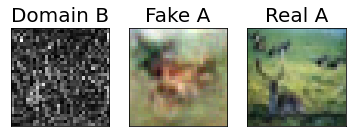

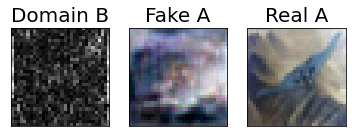

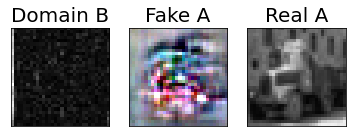

In [104]:
# Load random batch from dataset

for i in range(3):
  [im_A_real, im_B_test] = dataset_loader.get_random_batch(batch_size=1, is_training=False)

  im_A_fake = generator.predict(im_B_test)

  showColoredIms(im_B_test, im_A_fake, im_A_real)